# Example - Regional Comparison

This notebook takes the scenarios from the AR6 Scenarios Database and evaluates, filters, rates and visualises them.
It is focused on the comparison of different regions in the p-e-a, allowing you to explore regional differentiation in the package.

The AR6 scenarios database is hosted by IIASA: Edward Byers et al. 2022, "International Institute for Applied Systems Analysis", doi: [10.5281/zenodo.5886912](10.5281/zenodo.5886912) | url: [data.ece.iiasa.ac.at/ar6/](data.ece.iiasa.ac.at/ar6/)


# Package imports

Functions from the pathways_evaluation_analysis package

In [1]:
from pathways_evaluation_analysis.criteria import base, library
from pathways_evaluation_analysis.evaluation import (
    filter_rating,
    filter_values,
    get_values,
    rate,
)
from pathways_evaluation_analysis.plot import heatmap

<IPython.core.display.Javascript object>

Additional packages for data structures and processing

In [2]:
import numpy as np  # Used for creating rating / indicator functions
import pyam  # Useful for storing climate / energy scenario data

Warnings and logging

In [3]:
import logging

logging.basicConfig()
pyam.logger.setLevel(logging.ERROR)
logger = logging.getLogger()
logger.setLevel(
    "DEBUG"
)  # Set level to INFO to get information about what is going on behind the curtain

import warnings

%load_ext autoreload
%autoreload 2

# Download scenario data
We use the `pyam` package (https://pyam-iamc.readthedocs.io/en/stable/) to access and process data. This package can read local data (.csv or .xlsx format), or from an online scenario database. We use this second approach here, creating a connection to the AR6 database hosted by IIASA (https://data.ece.iiasa.ac.at/ar6).

Here we focus on data with R5 resolution.

In [4]:
%%time

conn = pyam.iiasa.Connection("ar6-public")

variables_required = [
    "Secondary Energy|Electricity|Non-Biomass Renewables",
    "Secondary Energy|Electricity|Coal|w/o CCS",
    "Secondary Energy|Electricity",
    "Primary Energy|Biomass",
    "Emissions|CO2",
    "Carbon Sequestration|CCS|Fossil",
    "Carbon Sequestration|CCS|Biomass",
    "Emissions|CO2|AFOLU",
]

r5_regions = [
    "Asian countries except Japan",
    "Countries of the Middle East and Africa",
    "Countries from the Reforming Ecomonies of the Former Soviet Union",
    "OECD90 and EU (and EU candidate) countries",
    "Latin American countries",
]

region_rename = {
    "Asian countries except Japan": "R5ASIA",
    "Countries of the Middle East and Africa": "R5MAF",
    "Countries from the Reforming Ecomonies of the Former Soviet Union": "R5REF",
    "OECD90 and EU (and EU candidate) countries": "R5OECD",
    "Latin American countries": "R5LAM",
}

warnings.filterwarnings("ignore")
data = conn.query(
    region=r5_regions,
    variable=variables_required,
)
warnings.resetwarnings()

# We pre-select a subset of scenarios which are likely to limit warming to 1.5°C
data_C1 = data.filter(Category="C1*")
data_C1 = data_C1.rename(region=region_rename)

DEBUG:httpx._client:HTTP Request: GET https://api.manager.ece.iiasa.ac.at/legacy/anonym/ "HTTP/1.1 200 OK"
DEBUG:httpx._client:HTTP Request: GET https://api.manager.ece.iiasa.ac.at/legacy/applications "HTTP/1.1 200 OK"
DEBUG:httpx._client:HTTP Request: GET https://api.manager.ece.iiasa.ac.at/legacy/applications/IXSE_AR6_PUBLIC/config "HTTP/1.1 200 OK"
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): db1.ene.iiasa.ac.at:443
DEBUG:urllib3.connectionpool:https://db1.ene.iiasa.ac.at:443 "GET /ar6-public-api/rest/v2.1/runs?getOnlyDefaultRuns=true&includeMetadata=true HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): db1.ene.iiasa.ac.at:443
DEBUG:urllib3.connectionpool:https://db1.ene.iiasa.ac.at:443 "GET /ar6-public-api/rest/v2.1/ts HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): db1.ene.iiasa.ac.at:443
DEBUG:urllib3.connectionpool:https://db1.ene.iiasa.ac.at:443 "GET /ar6-public-api/rest/v2.1/nodes?hierarchy

CPU times: user 13.6 s, sys: 2.7 s, total: 16.3 s
Wall time: 47.6 s


# Create criteria for ranking
This is a two step process

1. Define the criterion of interest (using the standard p-e-a libraries)
2. Define special CompareRegionalCriterion criteria - which take these pre-defined criterion and show how they will be used to compare one region against another (defining the regions of interest, and the method by which the regions are to be compared)

Step 1: Define criterion

Step 2: Define regional comparison criterion

In [5]:
criteria = []

criteria.append(
    base.CompareRegionsCriterion(
        criterion_name="Relative CO2 mitigation \n btwn developed and developing countries \n over 2020-2030 period",
        rating_function=lambda x: np.clip(0.5 - 2 * x, 0, 1),
        criterion_class=base.ChangeOverTimeCriterion,
        kwargs_criterion=dict(
            criterion_name="CO2 emissions in 2030 \n(relative to 2020)",
            year=2030,
            variable="Emissions|CO2",
            reference_year=2020,
            rating_function=lambda x: -x,
        ),
        region_1={"macro_region": "developed", "subregions": ["R5OECD", "R5REF"]},
        region_2={
            "macro_region": "developing",
            "subregions": ["R5ASIA", "R5MAF", "R5LAM"],
        },
        method="subtract",
    )
)

criteria.append(
    base.CompareRegionsCriterion(
        criterion_name="Relative share of coal \n btwn developed and developing countries \n in 2030",
        rating_function=lambda x: np.clip(0.5 - 2.5 * x, 0, 1),
        criterion_class=base.ShareCriterion,
        kwargs_criterion=dict(
            criterion_name="Coal share in 2030",
            year=2030,
            variable_component="Secondary Energy|Electricity|Coal|w/o CCS",
            variable_total="Secondary Energy|Electricity",
            rating_function=lambda x: x,
        ),
        region_1={"macro_region": "developed", "subregions": ["R5OECD", "R5REF"]},
        region_2={
            "macro_region": "developing",
            "subregions": ["R5ASIA", "R5MAF", "R5LAM"],
        },
        method="subtract",
    )
)

criteria.append(
    base.CompareRegionsCriterion(
        criterion_name="Relative BECCS deployment \n btwn developed and developing countries \n over 2040-2060",
        rating_function=lambda x: x,
        criterion_class=library.Mean_CarbonSequestration_Biomass,
        kwargs_criterion={},
        region_1={"macro_region": "developed", "subregions": ["R5OECD", "R5REF"]},
        region_2={
            "macro_region": "developing",
            "subregions": ["R5ASIA", "R5MAF", "R5LAM"],
        },
        method="divide",
    )
)

# Produce value matrix, rate, filter and plot

In [6]:
value_matrix = get_values(data_C1, criteria)

INFO:pathways_evaluation_analysis.evaluation:Determining values for: Relative CO2 mitigation 
 btwn developed and developing countries 
 over 2020-2030 period
INFO:pathways_evaluation_analysis.evaluation:Determining values for: Relative share of coal 
 btwn developed and developing countries 
 in 2030
INFO:pathways_evaluation_analysis.evaluation:Determining values for: Relative BECCS deployment 
 btwn developed and developing countries 
 over 2040-2060


In [7]:
logger.setLevel("INFO")
# Select only those pathways in which developed countries cut emissions faster than developing
filtered_matrix = filter_values(
    value_matrix,
    drop_conditions={
        "Relative CO2 mitigation \n btwn developed and developing countries \n over 2020-2030 period": {
            "mode": ">=",
            "value": 0,
        }
    },
)

INFO:pathways_evaluation_analysis.evaluation:64 Pathways with values >= 0 in criterion Relative CO2 mitigation 
 btwn developed and developing countries 
 over 2020-2030 period and will be dropped (32 left).


In [8]:
rated_matrix = rate(value_matrix, criteria)

INFO:pathways_evaluation_analysis.evaluation:Determining values for: Relative CO2 mitigation 
 btwn developed and developing countries 
 over 2020-2030 period
INFO:pathways_evaluation_analysis.evaluation:Determining values for: Relative share of coal 
 btwn developed and developing countries 
 in 2030
INFO:pathways_evaluation_analysis.evaluation:Determining values for: Relative BECCS deployment 
 btwn developed and developing countries 
 over 2040-2060


In [9]:
filtered_rated_matrix = filter_rating(rated_matrix, pathways_max=30)

INFO:pathways_evaluation_analysis.evaluation:Number of pathways: 95
INFO:pathways_evaluation_analysis.evaluation:Number of pathways after applying max_pathways limit: 30


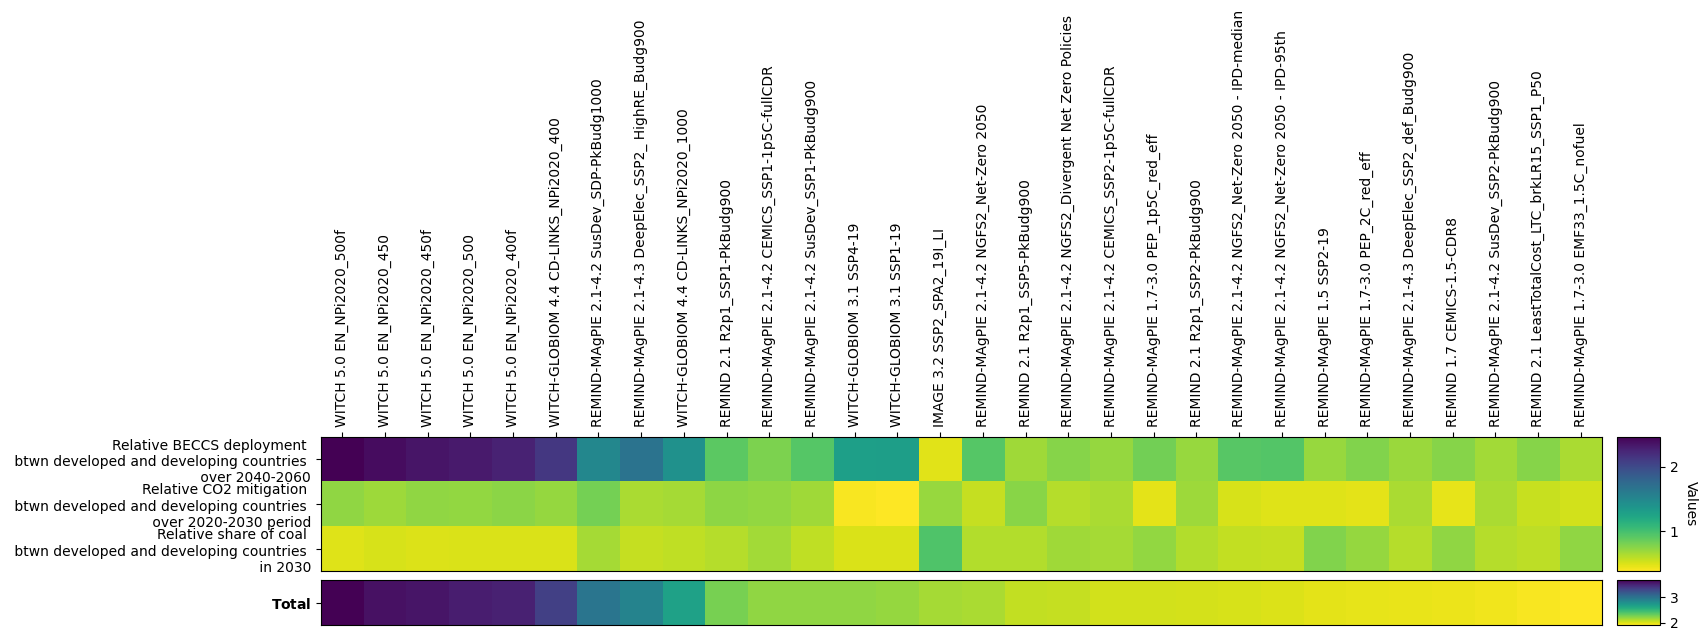

In [10]:
ax = heatmap(filtered_rated_matrix)